<a href="https://colab.research.google.com/github/LinggarM/Transformers-1.0/blob/master/Transformers_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [57]:
pip install transformers

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import tensorflow as tf

# Data Preparation

## Import Dummy Data (Ukara Dataset)
[https://github.com/aliakbars/ukara](https://github.com/aliakbars/ukara)

In [59]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [60]:
path = "/content/gdrive/MyDrive/Upload/Machine Learning/Projects/Transformers 1.0/Data/Dummy Data"
data_dev = f"{path}/Data A/data_dev_A.csv"
data_train = f"{path}/Data A/data_train_A.csv"

In [61]:
df_dev = pd.read_csv(data_dev)
df_train = pd.read_csv(data_train)

In [62]:
df_train.head()

,RES_ID,RESPONSE,LABEL
0,TRA1,intetraksi/beradaptasi terhadap lingkungan yan...,1
1,TRA2,seperti jatuhnya meteor tsunami gempa bumi,0
2,TRA3,hanya tuhan yang tahu tantangan nya itu apaan,0
3,TRA4,mereka akan sulit beradaptasi,1
4,TRA5,"Tempat tinggal, ekonomi, dan pekerjaan",1


In [63]:
df_dev.head()

,RES_ID,RESPONSE
0,DEVA1,karena di tempat tnggalnya tidak aman karena b...
1,DEVA2,"banyak yang menolak, susah mencari lapangan pe..."
2,DEVA3,ah berkomunikasi dengan wilyah yang mereka tem...
3,DEVA4,"tantangan yang akan mereka hadapi, seperti mer..."
4,DEVA5,Mereka akan tidak terbiasa dengan tempat baru


## Process Data

**Stimulus** : Pemanasan global terjadi karena peningkatan produksi karbon dioksida yang dihasilkan oleh pembakaran fosil dan konsumsi bahan bakar yang tinggi. Salah satu akibat adalah mencairnya es abadi di kutub utara dan selatan yang menimbulkan naiknya ketinggian air laut. kenaikan air laut akan terjadi terus menerus meskipun dalam hitungan centimeter akan mengakibatkan perubahan yang signifikan. Film “Waterworld”, adalah film fiksi ilmiah yang menunjukkan akibat adanya pemanasan global yang sangat besar sehingga menyebabkan bumi menjadi tertutup oleh lautan. Negara-negara dan daratan yang dulunya kering menjadi tengelamn karena terjadi kenaikan permukaan air laut. Penduduk yang dulunya bisa berkehidupan bebas menjadi terpaksa mengungsi ke daratan yang lebih tinggi atau tinggal diatas air.

**Pertanyaan** : Apa yang akan menjadi tantangan bagi suatu penduduk ketika terjadi situasi daratan tidak dapat ditinggali kembali karena tengelam oleh naiknya air laut?

In [64]:
# question initialization
stimulus = "Pemanasan global terjadi karena peningkatan produksi karbon dioksida yang dihasilkan oleh pembakaran fosil dan konsumsi bahan bakar yang tinggi. Salah satu akibat adalah mencairnya es abadi di kutub utara dan selatan yang menimbulkan naiknya ketinggian air laut. kenaikan air laut akan terjadi terus menerus meskipun dalam hitungan centimeter akan mengakibatkan perubahan yang signifikan. Film “Waterworld”, adalah film fiksi ilmiah yang menunjukkan akibat adanya pemanasan global yang sangat besar sehingga menyebabkan bumi menjadi tertutup oleh lautan. Negara-negara dan daratan yang dulunya kering menjadi tengelamn karena terjadi kenaikan permukaan air laut. Penduduk yang dulunya bisa berkehidupan bebas menjadi terpaksa mengungsi ke daratan yang lebih tinggi atau tinggal diatas air."
pertanyaan = "Apa yang akan menjadi tantangan bagi suatu penduduk ketika terjadi situasi daratan tidak dapat ditinggali kembali karena tengelam oleh naiknya air laut?"

In [65]:
# get answers data
jawaban_train = df_train['RESPONSE'].tolist()
jawaban_dev = df_dev['RESPONSE'].tolist()
data_jawaban = jawaban_train + jawaban_dev

In [66]:
# get answers data length
data_len = len(data_jawaban)

In [68]:
# set id_mahasiswa
id_mahasiswa = np.arange(data_len)

In [69]:
# create dataframe for dummy data
df_dummy = pd.DataFrame({'id_mahasiswa': id_mahasiswa, 'jawaban': data_jawaban})
df_dummy.head()

,id_mahasiswa,jawaban
0,0,intetraksi/beradaptasi terhadap lingkungan yan...
1,1,seperti jatuhnya meteor tsunami gempa bumi
2,2,hanya tuhan yang tahu tantangan nya itu apaan
3,3,mereka akan sulit beradaptasi
4,4,"Tempat tinggal, ekonomi, dan pekerjaan"


In [70]:
# get data (question, id, answers, and data length)
question = pertanyaan
id_answers = df_dummy['id_mahasiswa'].tolist()
answers = df_dummy['jawaban'].tolist()
total_answers = len(df_dummy)

In [71]:
# data limitation
max_data = 50
id_answers = id_answers[:max_data]
answers = answers[:max_data]
total_answers = max_data

# Encode Data (Pertanyaan & Jawaban)

## IndoBERT

### Import Model & Tokenizer

In [72]:
from transformers import BertTokenizer, AutoModel
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")

### Data Preprocessing (Tokenization, Padding, Vectorization)

#### Answers

In [73]:
encoded_answers = tokenizer(answers, padding= True, return_tensors="pt")

In [74]:
print(encoded_answers['input_ids'])

tensor([[    2,  1666, 15261,  ...,     0,     0,     0],
        [    2,   295, 16300,  ...,     0,     0,     0],
        [    2,   344,  1251,  ...,     0,     0,     0],
        ...,
        [    2,   267,   308,  ...,     0,     0,     0],
        [    2,   599,   119,  ...,     0,     0,     0],
        [    2,  8635,   224,  ...,     0,     0,     0]])


#### Question

In [75]:
# get answer encoding length
question_enc_len = len(encoded_answers['input_ids'][0])

In [76]:
encoded_question = tokenizer(question, max_length = question_enc_len, padding= 'max_length', return_tensors='pt')

In [77]:
print(encoded_question['input_ids'])

tensor([[    2,   387,    34,   150,   234,  4776,   396,   607,  2317,   640,
           597,  3461,  9840,   119,   173,  7378, 30356,   755,   211,  9390,
          8893,   213, 17486,   514,  1784, 30477,     3,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0]])


### Embedding

#### Question

In [78]:
embedded_question = model(torch.LongTensor(encoded_question['input_ids']).view(1,-1))

In [95]:
# get 'last_hidden_state' vector dimension
print(embedded_question['last_hidden_state'].shape)

torch.Size([1, 41, 768])


In [97]:
# get 'pooler_output' vector dimension
print(embedded_question['pooler_output'].shape)

torch.Size([1, 768])


In [199]:
# pooler_output (last 4 hidden states) get best result from paper https://arxiv.org/pdf/1810.04805.pdf
print(embedded_question['pooler_output'][0][:10])
print(torch.cat(tuple(embedded_question['last_hidden_state'][0][-4:])))
print(torch.sum(embedded_question['last_hidden_state'][0][-4:], dim=0))

tensor([-8.9305e-01, -7.7686e-01,  5.2353e-01, -5.4589e-01,  5.9358e-01,
        -7.1775e-01,  3.7165e-01,  9.0938e-01, -5.5386e-04, -8.6047e-01],
       grad_fn=<SliceBackward0>)
tensor([-0.4714,  0.3485,  0.9281,  ...,  0.0991, -0.4381,  0.1323],
       grad_fn=<CatBackward0>)
tensor([-1.4327e+00,  5.5742e-01,  4.5030e+00,  4.4450e+00, -4.4110e-01,
         2.5947e+00, -1.5760e+00,  2.7743e+00, -1.4935e-01,  1.6939e+00,
        -3.0849e+00, -3.0322e+00, -2.2727e+00,  1.8770e+00, -4.5083e+00,
         6.0758e+00, -3.1998e+00, -2.0938e+00, -8.5179e-01,  6.4602e+00,
         2.5565e+00,  6.1748e+00,  6.1207e-01, -2.8973e+00, -7.5682e-02,
         6.3534e+00, -3.3588e-02,  7.1756e-02,  3.6234e+00,  3.4828e+00,
         1.2861e+00, -5.3944e+00, -2.1874e-01, -4.8693e+00, -6.3279e+00,
         1.4662e+00,  7.8108e-02,  3.8683e+00, -5.5925e+00, -2.8312e+00,
        -3.3830e+00, -9.0223e-01, -4.8722e+00, -3.2790e+00, -2.1526e+00,
         3.9571e-02,  3.6963e+00, -1.4293e+00,  1.5486e+00,  3.

In [100]:
# get vector from mean of all hidden states
embeddedquestion_meanhiddenstate = torch.mean(embedded_question['last_hidden_state'][0], dim=0)

In [111]:
# get vector from sum of all hidden states
embeddedquestion_sumhiddenstate = torch.sum(embedded_question['last_hidden_state'][0], dim=0)

In [112]:
print(embedded_question['last_hidden_state'])

tensor([[[ 1.3860,  1.6921,  1.2233,  ..., -0.3143, -0.0187,  0.6325],
         [ 0.8425, -0.4155,  0.2525,  ..., -0.1358, -1.1921,  1.1689],
         [ 0.6814,  0.7837, -0.1358,  ...,  0.3423, -0.9431,  1.4636],
         ...,
         [-0.5308,  0.2529,  0.9454,  ...,  0.2480, -0.6178, -0.1041],
         [-0.3763,  0.1834,  1.3085,  ..., -0.0104, -0.3863, -0.1750],
         [-0.0542, -0.2274,  1.3209,  ...,  0.0991, -0.4381,  0.1323]]],
       grad_fn=<NativeLayerNormBackward0>)


#### Answers

In [27]:
embedded_answers = []
for i in range(total_answers) :
  x = torch.LongTensor(encoded_answers['input_ids'][i]).view(1,-1)
  x = model(x)
  embedded_answers.append(x)

In [28]:
# get 'last_hidden_state' vector dimension
print((embedded_answers[0]['last_hidden_state']).shape)

torch.Size([1, 41, 768])


#### Convert to Numpy

In [29]:
# question
embedded_question_np = embedded_question['last_hidden_state'].detach().numpy()

# answers
embedded_answers_np = []
for i in range(total_answers) :
  embedded_answers_np.append(embedded_answers[i]['last_hidden_state'].detach().numpy())
embedded_answers_np = np.array(embedded_answers_np)

## Word2vec

## Glove

## FastText

## TF-IDF

# Measure the Distance

## Define Distance Function

In [30]:
# euclidean distance
def euclideanDistance(x, y):
    dist = tf.sqrt(tf.reduce_sum(tf.square(x - y), 1))
    return dist

In [31]:
# euclidean mean distance
def euclideanMeanDistance(x, y):
    dist = tf.sqrt(tf.reduce_sum(tf.square(x - y), 1))
    return tf.reduce_mean(dist)

## Calculate the Distance

In [114]:
# euclidean mean distance
dist_list = []
for i in range(total_answers) :
  dist = euclideanMeanDistance(embedded_question_np[0], embedded_answers_np[i][0])
  dist_list.append(float(dist))

In [115]:
# data preview
dist_list

[30.316831588745117,
 30.867998123168945,
 30.318729400634766,
 31.135366439819336,
 30.716949462890625,
 28.639541625976562,
 27.880308151245117,
 30.669269561767578,
 35.90969467163086,
 31.170272827148438,
 30.685909271240234,
 29.189905166625977,
 30.621097564697266,
 31.993545532226562,
 28.58953094482422,
 30.343469619750977,
 23.947242736816406,
 28.443523406982422,
 29.437419891357422,
 31.859609603881836,
 26.424983978271484,
 31.218639373779297,
 30.158281326293945,
 28.1530818939209,
 29.342365264892578,
 29.264192581176758,
 29.923866271972656,
 29.955286026000977,
 31.163419723510742,
 24.5221004486084,
 28.65730094909668,
 31.037736892700195,
 28.861438751220703,
 28.311437606811523,
 29.114704132080078,
 28.480016708374023,
 31.62978172302246,
 26.445077896118164,
 31.0833740234375,
 29.802738189697266,
 31.228572845458984,
 29.41337776184082,
 28.824596405029297,
 31.777488708496094,
 30.472646713256836,
 31.074600219726562,
 31.215511322021484,
 30.57582664489746,
 30.

In [36]:
# get sorted index
id_sorted = np.argsort(dist_list)

In [116]:
print(id_sorted)

[16 29 20 37  6 49 23 33 17 35 14  5 30 42 32 34 11 25 24 41 18 39 26 27
 22  0  2 15 44 47 12  7 10  4 48  1 31 45 38  3 28  9 46 21 40 36 43 19
 13  8]


# Get Data to be Labeled (n% of Answers)

## Count the Data

In [117]:
#set the percentage of to be labeled data
percentage = 20

In [118]:
#count total data to be labeled
n_label_answers = int(percentage/100 * total_answers)
if (n_label_answers < 3) :
  print("Percentage too small!")
else :
  print("Data to be labeled : ", n_label_answers)

Data to be labeled :  10


## Choose the Data

In [40]:
n_each_answers = int(n_label_answers/3)
print("Data for each section (top, middle, and bottom) : ", n_each_answers)

Data for each section (top, middle, and bottom) :  3


In [41]:
n_rest_answers = n_label_answers % 3
print("Rest of the data : ", n_rest_answers)

Rest of the data :  1


In [119]:
n_extra_top = 0
n_extra_middle = 0
if (n_rest_answers > 0) :
  n_extra_top+= 1
  if (n_rest_answers > 1) :
    n_extra_middle+= 1

# set index of top data (closest data)
top = []
print("id_sorted : ", id_sorted)
for i in range(n_each_answers + n_extra_top) :
  top.append(id_sorted[i])

# choose index of middle data
start_idx = int((total_answers/2) - (n_each_answers/2))
id_sorted_middle = id_sorted[start_idx:]
print("id_sorted_middle : ", id_sorted_middle)
middle = []
for i in range(n_each_answers + n_extra_middle) :
  middle.append(id_sorted_middle[i])

# choose index of bottom data (farthest data)
id_sorted_reverse = np.flip(id_sorted)
print("id_sorted_reverse : ", id_sorted_reverse)
bottom = []
for i in range(n_each_answers) :
  bottom.append(id_sorted_reverse[i])

id_sorted :  [16 29 20 37  6 49 23 33 17 35 14  5 30 42 32 34 11 25 24 41 18 39 26 27
 22  0  2 15 44 47 12  7 10  4 48  1 31 45 38  3 28  9 46 21 40 36 43 19
 13  8]
id_sorted_middle :  [27 22  0  2 15 44 47 12  7 10  4 48  1 31 45 38  3 28  9 46 21 40 36 43
 19 13  8]
id_sorted_reverse :  [ 8 13 19 43 36 40 21 46  9 28  3 38 45 31  1 48  4 10  7 12 47 44 15  2
  0 22 27 26 39 18 41 24 25 11 34 32 42 30  5 14 35 17 33 23 49  6 37 20
 29 16]


## Display the Data

In [120]:
print("Top answers : ", top)
print("Answers : ")
for i in top : print(i, answers[i])

print("\nMiddle answers : ", middle)
print("Answers : ")
for i in middle : print(i, answers[i])

print("\nBottom answers : ", bottom)
print("Answers : ")
for i in bottom : print(i, answers[i])

Top answers :  [16, 29, 20, 37]
Answers : 
16 keadaan yg tidak memadai serta kurangnya fasilitas di tempat pengungsian kegiatan jadi tidak dapat dilakukan seperti biasanya maknanya mereka tidak bebas melakukan sesuatu
29 masalah yang dapatdidapatkan oleh pengngungsi itu adalah penggunaan bahasa, dan pencarian lapangan kerja, tempat tinggal.
20 satu tantangan yang akan dihadapi pengungsi adalah kehilangan pekerjaan mereka yaitu pekerjaan bertani atau nelayan dan itulah salah satu pencaharian mereka selama menetap di Travina.
37 Tantangan pengungsi iklim adalah lahan pekerjaan yang ia tempati dulu akan hilang, karena ia harus meninggalkan negaranya karena bencana lingkungan yang ada di negaranya.

Middle answers :  [27, 22, 0]
Answers : 
27 mereka akan kehilangan sebagian besar atau bahkan semua lahan pertanian mereka
22 karena,akan ada bencana alam yang akan datang
0 intetraksi/beradaptasi terhadap lingkungan yang baru.

Bottom answers :  [8, 13, 19]
Answers : 
8 Pada kasus-kasus sepert

In [44]:
print("INDEX, LABEL, ANSWERS")
for i in id_sorted: print(i, df_train.iloc[i]['LABEL'], answers[i])

INDEX, LABEL, ANSWERS
16 1 keadaan yg tidak memadai serta kurangnya fasilitas di tempat pengungsian kegiatan jadi tidak dapat dilakukan seperti biasanya maknanya mereka tidak bebas melakukan sesuatu
29 1 masalah yang dapatdidapatkan oleh pengngungsi itu adalah penggunaan bahasa, dan pencarian lapangan kerja, tempat tinggal.
20 1 satu tantangan yang akan dihadapi pengungsi adalah kehilangan pekerjaan mereka yaitu pekerjaan bertani atau nelayan dan itulah salah satu pencaharian mereka selama menetap di Travina.
37 1 Tantangan pengungsi iklim adalah lahan pekerjaan yang ia tempati dulu akan hilang, karena ia harus meninggalkan negaranya karena bencana lingkungan yang ada di negaranya.
6 0 Mereka tidak akan di hormati oleh orang layaknya mereka di hormati di dalam tempat tinggal mereka yang lama
49 1 penguisi iklim adalah orang orang yang terpaksa meningalkan komunikasi atau negaranya karena karena beencna
23 1 Mereka perlu adaptasi dan harus rela berpisah dengan tembat lamanya yang kemung

In [45]:
# get index of all of the selected data
idx_gabungan = top + middle + bottom
idx_gabungan

[16, 29, 20, 37, 27, 22, 0, 8, 13, 19]

## Set Score to the Selected Data

In [46]:
scoring = []
for i in idx_gabungan :
  print(i, answers[i])
  #input score
  score = input("Beri skor : ")
  scoring.append(score)

16 keadaan yg tidak memadai serta kurangnya fasilitas di tempat pengungsian kegiatan jadi tidak dapat dilakukan seperti biasanya maknanya mereka tidak bebas melakukan sesuatu
Beri skor : 5
29 masalah yang dapatdidapatkan oleh pengngungsi itu adalah penggunaan bahasa, dan pencarian lapangan kerja, tempat tinggal.
Beri skor : 3
20 satu tantangan yang akan dihadapi pengungsi adalah kehilangan pekerjaan mereka yaitu pekerjaan bertani atau nelayan dan itulah salah satu pencaharian mereka selama menetap di Travina.
Beri skor : 4
37 Tantangan pengungsi iklim adalah lahan pekerjaan yang ia tempati dulu akan hilang, karena ia harus meninggalkan negaranya karena bencana lingkungan yang ada di negaranya.
Beri skor : 4
27 mereka akan kehilangan sebagian besar atau bahkan semua lahan pertanian mereka
Beri skor : 2
22 karena,akan ada bencana alam yang akan datang
Beri skor : 1
0 intetraksi/beradaptasi terhadap lingkungan yang baru.
Beri skor : 1
8 Pada kasus-kasus seperti salah satunya yang terjadi 

In [121]:
print(scoring)

[5 3 4 4 2 1 1 5 1 1]


# Model Training

## Define the Data

### Get Testing Index

In [48]:
# get index of answers for testing data
idx_test = [item for item in id_sorted if item not in idx_gabungan]

In [49]:
len(idx_test)

40

### Training Data

In [126]:
# training data (answers)
answers_train = []
answers_train_embedded = []
for i in idx_gabungan :
  answers_train.append(answers[i])
  answers_train_embedded.append(embedded_answers_np[i])

# convert to numpy array
answers_train_embedded = np.array(answers_train_embedded)

In [127]:
print(answers_train[0])

keadaan yg tidak memadai serta kurangnya fasilitas di tempat pengungsian kegiatan jadi tidak dapat dilakukan seperti biasanya maknanya mereka tidak bebas melakukan sesuatu


In [128]:
print(answers_train_embedded[0])

[[[ 1.4981687   1.9895463   1.4366618  ... -0.4381882   0.38164082
    0.33246037]
  [-0.6881104   0.2772643   0.06054112 ...  0.9591753  -0.4295396
    0.44088417]
  [ 1.4169497   2.9107153  -0.7779296  ...  0.02065711  0.8974585
    1.2851793 ]
  ...
  [-0.5025038   0.52491224  1.0914981  ...  0.32548618 -0.6988723
   -0.4462425 ]
  [-0.47407913  0.5378214   1.4391465  ...  0.09295828 -0.42467636
   -0.49157196]
  [-0.25222093  0.17337945  1.3498544  ...  0.12966591 -0.36407587
   -0.30962542]]]


In [124]:
#labels
scoring_int = []
for i in scoring :
  scoring_int.append(int(i))
scoring = np.array(scoring_int)

In [129]:
print(scoring)

[5 3 4 4 2 1 1 5 1 1]


### Testing Data

In [131]:
# testing data (answers)
answers_test = []
answers_test_embedded = []
for i in idx_test :
  answers_test.append(answers[i])
  answers_test_embedded.append(embedded_answers_np[i])
answers_test_embedded = np.array(answers_test_embedded)

### Dimension Simplification

In [135]:
# simplify the dimension (drop axis = 1)
question_embedded = np.squeeze(embedded_question_np, axis = 0)
answers_train_embedded = np.squeeze(answers_train_embedded, axis = 1)
answers_test_embedded = np.squeeze(answers_test_embedded, axis = 1)

In [139]:
print("question_embedded : ", question_embedded.shape)
print("answers_train_embedded : ", answers_train_embedded.shape)
print("answers_test_embedded : ", answers_test_embedded.shape)

question_embedded :  (41, 768)
answers_train_embedded :  (10, 41, 768)
answers_test_embedded :  (40, 41, 768)


##Bi-LSTM

## Build the Architecture

In [142]:
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Flatten, Dense, Dropout, Activation

model = Sequential()
model.add(Input(input_embedded[0].shape))
model.add(Bidirectional(LSTM(32, return_sequences= True, dropout= 0.3, recurrent_dropout= 0.3)))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss = 'mean_squared_error',
              optimizer = 'rmsprop',
              metrics = ['accuracy', 'mae'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 41, 64)           205056    
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2624)              0         
                                                                 
 dropout_1 (Dropout)         (None, 2624)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                26250     
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 231,317
Trainable params: 231,317
Non-trainable params: 0
________________________________________________

### Train the Model

In [143]:
history = model.fit(input_embedded, scoring,
                    epochs = 50)

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 8.4315 - accuracy: 0.2000 - mae: 2.3673
Epoch 2/50
1/1 [==============================] - 0s 151ms/step - loss: 10.2942 - accuracy: 0.4000 - mae: 2.7915
Epoch 3/50
1/1 [==============================] - 0s 125ms/step - loss: 3.2760 - accuracy: 0.0000e+00 - mae: 1.6823
Epoch 4/50
1/1 [==============================] - 0s 119ms/step - loss: 0.3978 - accuracy: 0.4000 - mae: 0.3751
Epoch 5/50
1/1 [==============================] - 0s 119ms/step - loss: 0.1690 - accuracy: 0.4000 - mae: 0.3154
Epoch 6/50
1/1 [==============================] - 0s 128ms/step - loss: 0.1967 - accuracy: 0.2000 - mae: 0.3732
Epoch 7/50
1/1 [==============================] - 0s 121ms/step - loss: 0.1890 - accuracy: 0.4000 - mae: 0.3860
Epoch 8/50
1/1 [==============================] - 0s 126ms/step - loss: 0.2080 - accuracy: 0.4000 - mae: 0.3513
Epoch 9/50
1/1 [==============================] - 0s 136ms/step - loss: 0.1231 - accuracy: 0.4000 - ma

### Visualization

#### Loss

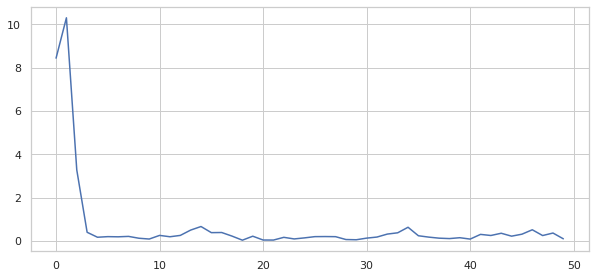

In [144]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['loss'])), y = history.history['loss'], palette='hls')

#### Metric: Accuracy

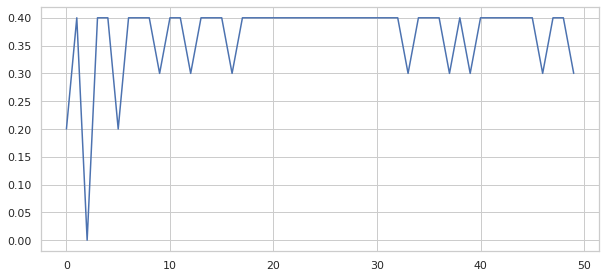

In [145]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['accuracy'])), y = history.history['accuracy'], palette='hls')

#### MAE

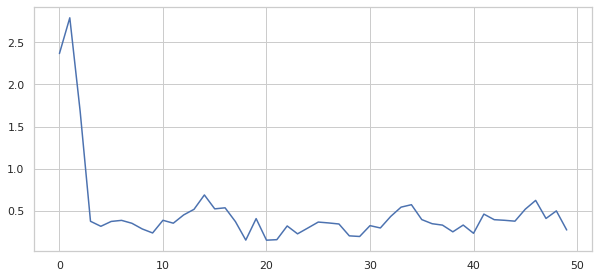

In [146]:
plt.figure(figsize=(10, 4.5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = np.arange(len(history.history['mae'])), y = history.history['mae'], palette='hls')

# Save Data

### Convert Data to DataFrame

In [163]:
id_answers_final = []
for i in idx_test :
  id_answers_final.append(id_answers[i])

In [177]:
score_predict = model.predict(answers_test_embedded)
score_predict = [float(i[0]) for i in score_predict]
score_int = [round(i) for i in score_predict]
# actual_labels = [df_train.iloc[i]['LABEL'] for i in idx_test]
df_final = pd.DataFrame({'id_mahasiswa': id_answers_final, 'answers': answers_test, 'score': score_predict, 'score (rounded)': score_int})
df_final.head()

,id_mahasiswa,answers,score,score (rounded)
0,6,Mereka tidak akan di hormati oleh orang layakn...,2.677892,3
1,49,penguisi iklim adalah orang orang yang terpaks...,2.255489,2
2,23,Mereka perlu adaptasi dan harus rela berpisah ...,2.509572,3
3,33,"MEREKA AKAN MENINGGALKAN NEGARANYA, DAN MEREKA...",2.782323,3
4,17,Pengungsi iklim adalah orang-orang yang terpak...,2.530999,3


## Save to CSV

### Direct Save

In [169]:
df_final.to_excel("scoring_result.xlsx", index = False)

### Auto Adjust Column Width

In [178]:
pip install xlsxwriter

In [176]:
filename = 'scoring_result.xlsx'
dfs = {'df_final': df_final}

writer = pd.ExcelWriter(filename, engine='xlsxwriter')
for sheetname, df in dfs.items():  # loop through `dict` of dataframes
    df.to_excel(writer, sheet_name=sheetname, index = False)  # send df to writer
    worksheet = writer.sheets[sheetname]  # pull worksheet object
    for idx, col in enumerate(df):  # loop through all columns
        series = df[col]
        max_len = max((
            series.astype(str).map(len).max(),  # len of largest item
            len(str(series.name))  # len of column name/header
            )) + 1  # adding a little extra space
        worksheet.set_column(idx, idx, max_len)  # set column width
writer.save()